<a href="https://colab.research.google.com/github/FlorianGelb/GNNProject/blob/K_sparse/K_SAE_nonoise_data_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import numpy as np

%matplotlib inline

In [ ]:
transform = transforms.ToTensor()
dataset = datasets.MNIST("./", download=True,transform = transform)
#dataset = datasets.FashionMNIST("./", download=True,transform = transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 55835928.10it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6000381.11it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22060541.11it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14069814.45it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw


In [ ]:
subset_size=int(0.3 * dataset.__len__())

In [ ]:

indices = torch.randperm(len(dataset)).tolist()
subset_indices = indices[:subset_size]
subset_dataset = Subset(dataset, subset_indices)

In [ ]:
# Split the subset dataset into train and test sets
train_size = int(0.8 * len(subset_dataset))  # 80% for training
test_size = len(subset_dataset) - train_size  # Remaining for testing

train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
from K_SAE import Net,plot,train,test

In [ ]:

sequence = [50 - 5 * i for i in range(10)]
print(sequence)

[50, 45, 40, 35, 30, 25, 20, 15, 10, 5]


In [ ]:

layers=[28*28,128,64,50]
#models = {"15": Net(layers,15), "20": Net(layers,20),"50": Net(layers,50), "80": Net(layers,80),"128": Net(layers,128)}
models={str(k): Net(layers,k) for k in sequence}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
models["50"]

Net(
  (E): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=50, bias=True)
    )
  )
  (D): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=50, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=784, bias=True)
    )
  )
)

In [ ]:
for epoch in range(1, 50):
    for model in models.values():
        model.train()
    train(train_loader,epoch, models, train_log)

    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)


Train Epoch: 1 [0/14400 (0%)]	Losses 50: 0.013704 45: 0.014699 40: 0.015588 35: 0.017024 30: 0.017022 25: 0.018154 20: 0.021551 15: 0.022918 10: 0.026644 5: 0.034282
Train Epoch: 1 [12800/14400 (89%)]	Losses 50: 0.017559 45: 0.018941 40: 0.020336 35: 0.022338 30: 0.022111 25: 0.023595 20: 0.028024 15: 0.028933 10: 0.034820 5: 0.041877
Train Epoch: 1 [14400/14400 (100%)]	Losses 50: 0.016793 45: 0.018215 40: 0.019216 35: 0.020840 30: 0.021521 25: 0.022619 20: 0.026943 15: 0.027935 10: 0.033323 5: 0.040292
Test set:
50: loss: 0.0159	
45: loss: 0.0172	
40: loss: 0.0182	
35: loss: 0.0200	
30: loss: 0.0201	
25: loss: 0.0216	
20: loss: 0.0256	
15: loss: 0.0263	
10: loss: 0.0313	
5: loss: 0.0394	

Train Epoch: 2 [0/14400 (0%)]	Losses 50: 0.016798 45: 0.018062 40: 0.018986 35: 0.021170 30: 0.021061 25: 0.022214 20: 0.026938 15: 0.028295 10: 0.032465 5: 0.041801
Train Epoch: 2 [12800/14400 (89%)]	Losses 50: 0.015997 45: 0.017032 40: 0.018107 35: 0.020077 30: 0.020238 25: 0.021748 20: 0.026525 15

In [ ]:
for k in models:
  torch.save(models[k].state_dict(), f'withoutnoise_MINST_weights_{k}_Relu.pth')

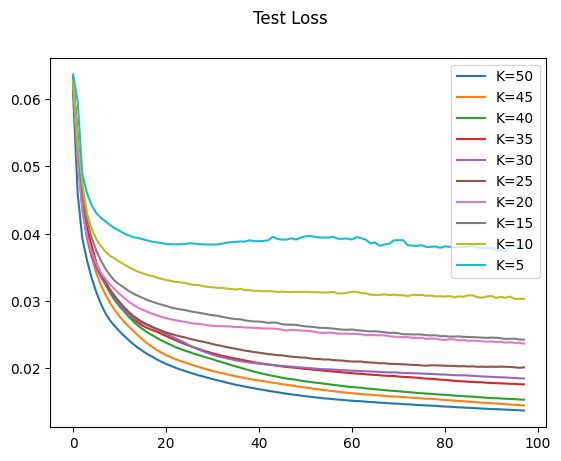

In [ ]:
for k in test_log:
    plt.plot(test_log[k], label=f'K={k}')

plt.legend()
plt.suptitle('Test Loss')
plt.show()


In [ ]:


# Encoder and decoder classes

class Encoder(nn.Module):
    def __init__(self, layers_dim,k):
        super(Encoder, self).__init__()
        self.layers_dim = layers_dim
        self.k=k

        layers = []
        for i in range(len(layers_dim)-2):
            layers.append(nn.Linear(layers_dim[i], layers_dim[i+1]))
            #layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))
        #layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)

        raw=encoded.detach().numpy()

        k=self.k
        mask = np.ones(raw.shape, dtype=bool)
        if k < raw.shape[1]:
            for i, row in enumerate(raw):
                # Find the indices of the top k elements in each row
                indices = np.argpartition(row, -k)[-k:]

                # Update the mask to set elements at indices to False
                mask[i, indices] = False
                raw[i,mask[i]]=0
        return encoded
class Decoder(nn.Module):
    def __init__(self, layers_dim):
        super(Decoder, self).__init__()
        self.layers_dim = layers_dim

        layers = []
        for i in range(len(layers_dim)-2):
            layers.append(nn.Linear(layers_dim[i], layers_dim[i+1]))
            #layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))
        #layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)


    def forward(self, y):
        decoded = self.decoder(y)


        return decoded


In [ ]:
# Class for autoencoder

class Net(nn.Module):
    def __init__(self, layers,k,loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.layers = layers
        self.E = Encoder(layers,k)
        self.D= Decoder(layers[::-1])
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        code = self.E(x)
        out = self.D(code)


        return out

    def decode(self, h):
        with torch.no_grad():
            decoded=self.D(h)
            return decoded


    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss






In [ ]:

layers=[28*28,128,64,50]
#models = {"15": Net(layers,15), "20": Net(layers,20),"50": Net(layers,50), "80": Net(layers,80),"128": Net(layers,128)}
models={str(k): Net(layers,k) for k in sequence}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
models["50"]

Net(
  (E): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=50, bias=True)
    )
  )
  (D): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=50, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=784, bias=True)
    )
  )
)

In [ ]:
for epoch in range(1, 50):
    for model in models.values():
        model.train()
    train(train_loader,epoch, models, train_log)

    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)


Train Epoch: 1 [0/14400 (0%)]	Losses 50: 0.011922 45: 0.022060 40: 0.023532 35: 0.025231 30: 0.025243 25: 0.023130 20: 0.024502 15: 0.026701 10: 0.032852 5: 0.039310
Train Epoch: 1 [12800/14400 (89%)]	Losses 50: 0.011653 45: 0.023079 40: 0.025102 35: 0.026367 30: 0.026266 25: 0.024988 20: 0.025374 15: 0.028646 10: 0.034648 5: 0.041609
Train Epoch: 1 [14400/14400 (100%)]	Losses 50: 0.011418 45: 0.021397 40: 0.022780 35: 0.024564 30: 0.024411 25: 0.022927 20: 0.023898 15: 0.026549 10: 0.030824 5: 0.038376
Test set:
50: loss: 0.0123	
45: loss: 0.0232	
40: loss: 0.0248	
35: loss: 0.0263	
30: loss: 0.0268	
25: loss: 0.0247	
20: loss: 0.0253	
15: loss: 0.0285	
10: loss: 0.0337	
5: loss: 0.0411	

Train Epoch: 2 [0/14400 (0%)]	Losses 50: 0.011191 45: 0.021631 40: 0.023680 35: 0.024831 30: 0.025237 25: 0.023378 20: 0.023551 15: 0.027460 10: 0.033051 5: 0.039494
Train Epoch: 2 [12800/14400 (89%)]	Losses 50: 0.012392 45: 0.024704 40: 0.026530 35: 0.028012 30: 0.028870 25: 0.025808 20: 0.026753 15

In [ ]:
for k in models:
  torch.save(models[k].state_dict(), f'withoutnoise_MINST_weights_{k}_linear.pth')


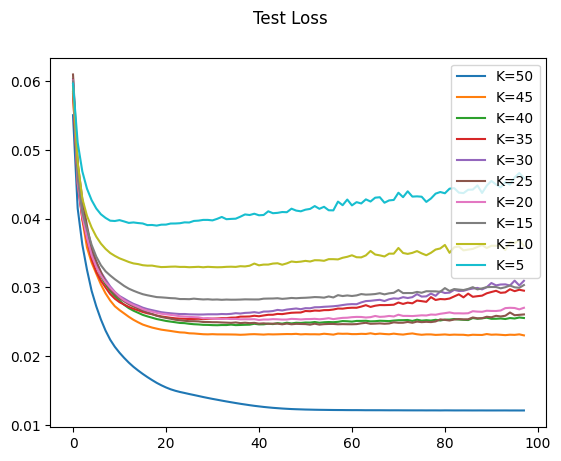

In [ ]:
for k in test_log:
    plt.plot(test_log[k], label=f'K={k}')

plt.legend()
plt.suptitle('Test Loss')
plt.show()
